# Assingment #4

## Part2 Stitching images (90 points):

In an iPython notebook stitching.ipynb, import the following

```python
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 # yes, you can do this, but see below!
```

Go outside the science library onto the grass and take **10 pictures** of the campus,
taking care that each picture overlaps with the other, but that you also cover some
large area. The pictures need to be submitted with your assignment, of course.

Then implement the full stitching pipeline using a nice set of functions. 
Each function is described below – the input and output parameters should be clear:

`loadImages`: Load images, convert them to double and to grayscale. Return list of
images.

`getFeaturePoints`: Detect feature points in an image, using the (Harris) corner
detector you developed in Assignment 3. Save them in a list and return. The function
should also plot the detected feature points in the image.

`getFeatureDescriptors`: For a given input list of feature points, extract its
neighborhood using the pixel values in a small window around each point as a feature
vector. The window size needs to be a parameter of the function. Return the feature
vectors as another list.

`match2Images`: Given lists of feature points and feature descriptors from two
images, match them. For this, compute distances between every descriptor in one
image and every descriptor in the other image – Euclidean distance may work, but
more robust matching can be done with normalized cross correlation (look it up, it’s
easy!) of the descriptors. Implement both ways and check later which gives better
results. Select matches based on the ratio criterion with a suitable threshold (this is a
function parameter). The function should also plot the matches between the two
images. Return the matches as a list of indices in the two images.

`refineMatches`: Given lists of feature points and the match list, implement
RANSAC to estimate a homography mapping one image onto the other (so, the full
number of 8 parameters). In each iteration of RANSAC, simply select 4 points at
random, estimate the homography by finding the nullspace of the transform (see
lecture 6!). This function also needs parameters for inlier thresholds and rounds of
iterations with which you need to experiment. Return the estimated homography.
When running the function, it should print out the number of inliers that survive
RANSAC and the average residual for the inliers (squared distance between the point
coordinates in one image and the transformed coordinates of the matching point in
the other image). Finally, the function should plot the surviving matches.

`warpImages`: given a list of homographies and a list of n images, warp images 2-n
onto the image space of image 1. For this, you are allowed to use the OpenCV
function warpPerspective, which will work with your estimated homography
(take care though in which direction you estimated the homography!!). In the
function you will need to first create a new image big enough to hold all stitched
images and then use warpPerspective to composite the two images into it. Use
averaging of pixels for the stitching. Return the full stitched image and have the
function also plot the result.

**Implement all functions with nice commenting, and experiment with parameters
of the functions such that they work, also make notes of your experiments and
explain your choice of parameter in the iPython-notebook!**

Tips:
- Make sure that the images have enough overlap, otherwise our very simple
feature descriptors may not work
- I would recommend to also resize the images, so that they are maximum of
1000x800 or something similar – if you use too high-res images, this pipeline
will get too slow
- You can and should sanity check your steps by using the inbuilt OpenCV
functions for Harris detectors and/or ORB features as well as RANSAC
matching the important functions for this would be [ORB_create,
detectAndCompute; BFMatcher_create, match].
- **If you cannot make your own version to work, please include at least a
version that does the job with OpenCV – if you do this the assignment will
only be worth 30 points.**

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 # yes, you can do this, but see below!

import os
from os.path import isfile, join
from tqdm.auto import tqdm
from PIL import Image

%matplotlib inline

## loadImages

In [2]:
def rgb2gray(rgb):
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return gray

In [3]:
def loadImages(path):
    frame_array = []
    files = [f for f in os.listdir(path) if isfile(join(path, f))]
    files.sort()
    
    for i in range(len(files)):
        filename = path + files[i]
        #reading each files
        img = plt.imread(filename)
        img = rgb2gray(img)
    
        #inserting the frames into an image array
        frame_array.append(img)
    
    return frame_array

In [4]:
def img_resize(pathIn, pathOut):
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files.sort()
    
    if not os.path.exists(pathOut):
        os.makedirs(pathOut)
    else:
        print(pathOut + " has been processed!")
    
    for i in range(len(files)):
        filename = pathIn + files[i]
        #reading each files
        img = Image.open(filename)
        if img.size == (4032, 3024):
            img = img.resize((1008, 756))
        
        img.save(f"{pathOut}{files[i]}.png",'png')

In [5]:
img_resize('./image/images_01/', './image/rimages_01/')

./image/rimages_01/ has been processed!


In [6]:
images = loadImages('./image/rimages_01/')

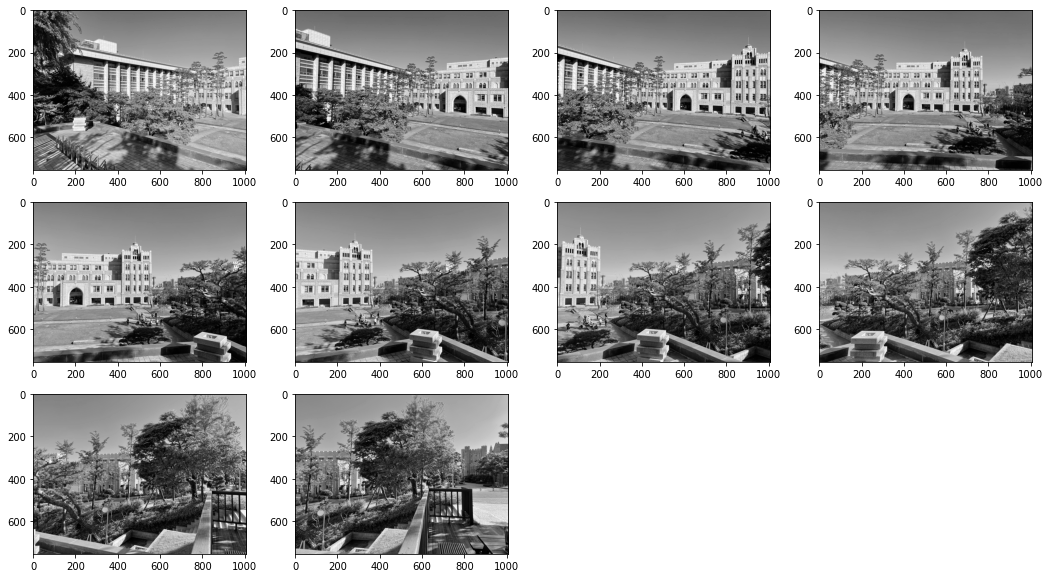

In [7]:
plt.figure(figsize=(18, 10))

for i, img in enumerate(tqdm(images)):
    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray')
plt.show()

### getFeaturePoints

In [8]:
def convolution(img: np.array, weights: np.array):
    """
    Convolution with weights filter
    
    Arguments
    ---------
    - img      : image
    - weights  : filter weights
    
    Return
    ------
    - filtered : filtered image
    
    """
    weights = weights.astype(float)
    filtered = np.zeros_like(img)
    
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]=np.sum(weights*img[j-width:j+width+1,i-height:i+height+1])
            
    return filtered

def cornerDetect(img: np.array, winSize: int = 7, type: int = 0):
    """
    Corner Detection
    
    Arguments
    ---------
    - img     : image # we are only doing grayscale images,
    - winSize : total size of window for summation in pixels,
    - type    : {0 – Eigenvalue, 1 – Harris}
    
    Return
    ------
    - l1      : detected corner array by Eigenvalue
    - h       : detected corner array by Herris
    """
    
    # sobel filter by axis
    filter_sobelx = np.array([
        (-1,0,1),
        (-2,0,2),
        (-1,0,1)
    ])
    filter_sobely = np.array([
        (-1,-2,-1),
        (0,0,0),
        (1,2,1)
    ])
    
    # convolution
    imgdx = convolution(img, 1/8*filter_sobelx)
    imgdy = convolution(img, 1/8*filter_sobely)
    
    # define array
    corner = np.zeros_like(img)
    
    # Ixx, Iyy, Ixy
    ix2 = imgdx*imgdx
    iy2 = imgdy*imgdy
    ixy = imgdx*imgdy
    
    # calcuate Eigenvalue and Herris by window
    for y in range(0+winSize, img.shape[0]-1-winSize):
        for x in range(0+winSize, img.shape[1]-1-winSize):
            sx2 = np.sum(ix2[y-winSize:y+winSize, x-winSize:x+winSize])
            sy2 = np.sum(iy2[y-winSize:y+winSize, x-winSize:x+winSize])
            sxy = np.sum(ixy[y-winSize:y+winSize, x-winSize:x+winSize])
            
            # H
            tmpH = np.array([(sx2,sxy), (sxy,sy2)])

            if type==0:
                # Eigenvalues
                corner[y,x], _ = np.sort(np.linalg.eigvals(tmpH))
            elif type==1:
                # Herris
                ttmp = np.trace(tmpH)
                if ttmp != 0:
                    corner[y,x] = np.linalg.det(tmpH)/ttmp
            
    return corner          

In [9]:
def getFeaturePoints(image_list, winSize, threshold):
    plt.figure(figsize=(15, 10))

    fp_list = []
    herris_result = []
    
    for i, img in enumerate(tqdm(image_list)):
        herris_cor = cornerDetect(img, winSize, type=1) > threshold
        fp_list.append(np.argwhere(herris_cor==True))
        herris_cor_x = np.argwhere(herris_cor==True)[:,1]
        herris_cor_y = np.argwhere(herris_cor==True)[:,0]
        
        plt.subplot(3, 4, i+1)
        plt.imshow(img, cmap='gray')
        plt.scatter(herris_cor_x, herris_cor_y, color='red')
    
    plt.show()
    return fp_list

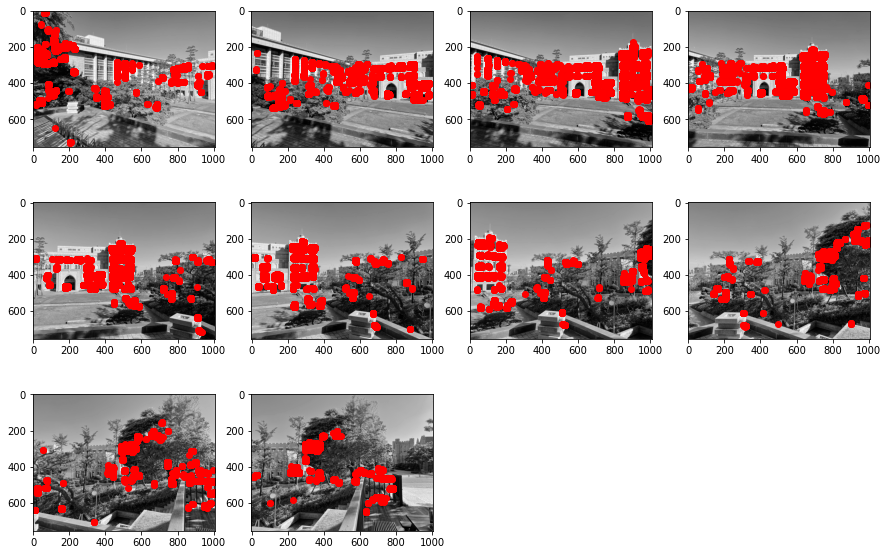

In [10]:
fp_list = getFeaturePoints(images, winSize=5, threshold=0.8)

## getFeatureDescriptors

In [37]:
def getFeatureDescriptors(fp_list, images, winSize=16, num_bins=8):
    
    descriptors = []
    
    # sobel filter by axis
    filter_sobelx = np.array([
        (-1,0,1),
        (-2,0,2),
        (-1,0,1)
    ])
    filter_sobely = np.array([
        (-1,-2,-1),
        (0,0,0),
        (1,2,1)
    ])

    for i, fps in enumerate(fp_list):
        image = images[i]
        num_rows, num_cols = image.shape
        
        padding_img = np.zeros((num_rows+winSize, num_cols+winSize))
        halfSize = int(winSize/2)
        padding_img[halfSize:-halfSize, halfSize:-halfSize] = image
        
        descriptor = []
        
        for fp in fps:
            paths = np.zeros((winSize, winSize, 2))
            path_img = padding_img[fp[0]:fp[0]+winSize, fp[1]:fp[1]+winSize]
            dev_x = convolution(path_img, 1/8*filter_sobelx)
            dev_y = convolution(path_img, 1/8*filter_sobely)
                    
            orientation = np.arctan(dev_y, dev_x) * 180 / np.pi
            magnitude = np.sqrt(dev_x**2+dev_y**2)
            
            bins_per_degree = num_bins / 360.        

            
            for i, ori in orientation:
                
            
#             paths[:,:,0] = orientation
#             paths[:,:,1] = magnitude
                                    
        
    
    

In [38]:
getFeatureDescriptors(fp_list, images)

In [18]:
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    descriptors = []

    for keypoint in keypoints:
        num_rows, num_cols = gaussian_images.shape
        point = keypoint
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')


In [21]:
np.argwhere(fp_list[0]==True)

array([[  5,  61],
       [  5,  62],
       [  5,  63],
       ...,
       [730, 207],
       [731, 205],
       [731, 206]])

## match2Images

## refineMatches

## warpImages

---